# NLP GitHub README Language Analysis
##### by Matt Zapata and Orion Wills

# PLAN

- [x] Acquisition
    - [x] Select what list of repos to scrape.
    - [x] Get requests form the site.
    - [x] Save responses to csv.
- [x] Preparation
    - [x] Prepare the data for analysis.
- [x] Exploration
    - [x] Answer the following prompts:
        - [x] What are the most common words in READMEs?
        - [x] What does the distribution of IDFs look like for the most common words?
        - [x] Does the length of the README vary by language?
        - [x] Do different languages use a different number of unique words?
- [x] Modeling
    - [x] Transform the data for machine learning; use language to predict.
    - [x] Fit several models using different text repressentations.
    - [x] Build a function that will take in the text of a README file, and makes a prediction of language.
- [ ] Delivery
    - [ ] Github repo
        - [x] This notebook.
        - [x] Documentation within the notebook.
        - [x] README file in the repo.
        - [x] Python scripts if applicable.
    - [ ] Google Slides
        - [x] 1-2 slides only summarizing analysis.
        - [x] Visualizations are labeled.
        - [x] Geared for the general audience.
        - [x] Share link @ readme file and/or classroom.

# ENVIRONMENT

In [3]:
# disable warnings
import warnings
warnings.filterwarnings("ignore")

import unicodedata
import re
from requests import get
import json
# import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import pandas as pd
import time
import csv
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#Global variables holding all of our language names and additional stopwords
LANGUAGES = ['JavaScript', 'Rust', 'C++', 'Python', 'Dart', 'Java', 'Go', 'CSS',
            'PHP', 'TypeScript', 'Ruby', 'HTML', 'C', 'Vue', 'C#', 'Shell',
            'Clojure', 'Objective-C', 'Swift', 'Jupyter Notebook',
            'Vim script', 'Assembly', 'Kotlin', 'Dockerfile', 'TeX', 'javascript', 'rust', 'c++', 'python', 'dart',
             'java', 'go', 'css', 'php', 'typescript', 'ruby', 'html', 'c', 'vue', 'c#', 'shell', 'clojure', 
             'objective-c', 'swift', 'jupyter notebook', 'vim script', 'assembly', 'kotlin', 'dockerfile', 'tex']

BASEURL = 'https://github.com/search?p=1&q=stars%3A%3E0&s=stars&type=Repositories'
HEADERS = {'User-Agent': 'Definitely not Sentient Attack Helicoptor'}

# ACQUIRE

First thing that needs to happen is to get the links from the most starred github repositories.  The most complicated part here was identifying the section that had the actual urls.

The `get_url_list` function does the following:
* get a response from the BASEURL
* set number of pages to scrape and loop through all of them
* find the list of all the repos on the page
* from that list find the individual list item repos
* do a check to see if there is a language associated with the repo
* * if no language, skip
* loop through individual repo sections and grab the url
* print out a list of the total valid urls scraped
* save the resulting list of urls to a csv
* return the urls

In [2]:
def get_url_list(page):
    urls = []
    response = get(BASEURL, headers=HEADERS)
    soup = BeautifulSoup(response.content)
    max_page = page + 1
    for i in range(1,max_page):
        url = 'https://github.com/search?p=' + str(i) + '&q=stars%3A%3E0&s=stars&type=Repositories'
        print(f'traversing url: {url}')
        response = get(url, headers=HEADERS)
        soup = BeautifulSoup(response.text)
        list_of_repos = soup.find('ul', class_='repo-list')
        repository = list_of_repos.find_all('li', class_='repo-list-item')
        for h in repository:
            if h.find(attrs={'itemprop':'programmingLanguage'}):
                a = h.find('a')
                urls.append(a.attrs['href'])
        time.sleep(3)
    print(f'Scraped a total of {len(urls)} github urls.')
    urls = ['https://github.com' + url for url in urls]
    with open('github_urls.csv', 'w') as f:
        ghub_urls = csv.writer(f, delimiter=',')
        ghub_urls.writerow(urls)
    return urls


Now that we have the list of urls from `get_url_list`, we need to do the following:
* visit each of the urls
* find the main body of the `README.md`
* * if there is no body in the `README.md` then skip it
* grab the readme info
* find the prominent language and grab that as well
* do this for all the urls in the list from the previous function

In [3]:
def grab_readmes_and_languages(urls):
    readmes = []
    languages = []
    for url in urls:
        response = get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        if soup.find('div', class_='Box-body') == None:
            continue
        else:
            single_readme = soup.find('div', class_='Box-body').text
        if soup.find('span', class_='lang') == None:
            continue
        else:
            repo_language = soup.find('span', class_='lang').text
        languages.append(repo_language)
        readmes.append(single_readme)
    df = pd.DataFrame({'readme':readmes, 'language':languages})
    return df

Now that we have a big bunch of words and languages in a dataframe, we need to do some cleanup.  These functions will do the following:
* lowercase all the text
* normalize the language into english-only
* only keep words that start with letters, numbers, or whitespace
* strip any whitespace at the start or the end of a word
* replace any newlines with a space
* tokenize the words
* either stem or lemmatize the words
* remove all standard stopwords as well as the languages and any additional stopwords that were found during exploration

In [7]:
def basic_clean(string):
    """
    Will lowercase, normalize, and remove anything that isn't a letter, number,
    whitespace or single quote and return it.
    """
    clean_string = string.lower()
    clean_string = unicodedata.normalize('NFKD', clean_string).\
                    encode('ascii', 'ignore').\
                    decode('utf-8', 'ignore')
    clean_string = re.sub(r'[^a-z0-9\s]', '', clean_string)
    clean_string = clean_string.strip()
    clean_string = re.sub(r'\s+', ' ', clean_string)
    # remove all single characters or numbers
    clean_string = re.sub(r'(^| ).( |$)', '', clean_string)
    clean_string = re.sub(r'(^| )[0-9]( |$)', '', clean_string)
    return clean_string

def tokenize(string, string_or_list='string'):
    """nltk.tokenize.ToktokTokenizer"""
    tokenizer = nltk.tokenize.ToktokTokenizer()
    if string_or_list == 'string':
        return tokenizer.tokenize(string, return_str=True)
    if string_or_list == 'list':
        return tokenizer.tokenize(string)
    
def stem(string, string_or_list='string'):
    """Returns the stems."""
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in string.split()]
    stemmed_string = ' '.join(stems)
    if string_or_list == 'list':
        return stems
    if string_or_list == 'string':
        return stemmed_string
    
def lemmatize(string, string_or_list='string'):
    """Returns the lemmatized text."""
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    lemmatized_string = ' '.join(lemmas)
    if string_or_list == 'string':
        return lemmatized_string
    if string_or_list == 'list':
        return lemmas
    
def remove_stopwords(string, string_or_list='string', extra_words=None, exclude_words=None):
    """Removes the stopwords from the text then returns it. Able to add or remove stopwords."""
    stopword_list = stopwords.words('english')
    if extra_words != None:
        for word in extra_words:
            stopword_list.append(word)
    if exclude_words != None:
        for word in exclude_words:
            stopword_list.remove(word)
    filtered_words = [word for word in string.split() if word not in stopword_list]
    filtered_string = ' '.join(filtered_words)
    if string_or_list == 'string':
        return filtered_string
    if string_or_list == 'list':
        return filtered_words
    
def remove_stopwords2(string, string_or_list='string', extra_words=None, exclude_words=None):
    """Removes the stopwords from the text then returns it. Able to add or remove stopwords."""
    stopword_list = stopwords.words('english') + LANGUAGES
    if extra_words != None:
        for word in extra_words:
            stopword_list.append(word)
    if exclude_words != None:
        for word in exclude_words:
            stopword_list.remove(word)
    filtered_words = [word for word in string.split() if word not in stopword_list]
    filtered_string = ' '.join(filtered_words)
    if string_or_list == 'string':
        return filtered_string
    if string_or_list == 'list':
        return filtered_words
    
def remove_languages(string, string_or_list='string', extra_words=None, exclude_words=None):
    """Removes the stopwords from the text then returns it. Able to add or remove stopwords."""
    stopword_list = stopwords.words('english') + LANGUAGES
    if extra_words != None:
        for word in extra_words:
            stopword_list.append(word)
    if exclude_words != None:
        for word in exclude_words:
            stopword_list.remove(word)
    filtered_words = [word for word in string.split() if word not in stopword_list]
    filtered_string = ' '.join(filtered_words)
    if string_or_list == 'string':
        return filtered_string
    if string_or_list == 'list':
        return filtered_words

# fancy pipe function
def pipe(v, *fns):
    return reduce(lambda x, f: f(x), fns, v)

def readme_lem(text):
    return pipe(text, basic_clean, tokenize, remove_stopwords, lemmatize)

def readme_lem2(text):
    return pipe(text, basic_clean, tokenize, remove_stopwords2, lemmatize)

def readme_stem(text):
    return pipe(text, basic_clean, tokenize, remove_stopwords, stem)

def readme_stem2(text):
    return pipe(text, basic_clean, tokenize, remove_stopwords2, stem)

If we already have the urls, we don't need to re-scrape them.

In [ ]:
with open('github_urls.csv') as f:
    urls = f.readlines()
urls = urls[0].split(',')

Checking to make sure the size of the list of urls makes sense.

In [ ]:
len(urls)

Scraping the information we need from GitHub with our function and storing it in a dataframe.

In [ ]:
df = grab_readmes_and_languages(urls)
df.head(10)

To keep us from having to rescrape, save the dataframe to a csv.

In [ ]:
df.to_csv('github_data.csv')

Read the CSV data if we already have it saved.

In [8]:
df = pd.read_csv('full_719.csv')
print(df.shape)
df.head()

(719, 2)


,readme,language
0,\n\n\n\nMarked\n\n\n\n\n\n\n\n\n\n⚡ built for ...,JavaScript
1,\nNetty Project\nNetty is an asynchronous even...,Java
2,"\nReact Starter Kit — ""isomorphic"" web app boi...",JavaScript
3,"\nUppy\n\n\n\nUppy is a sleek, modular JavaScr...",JavaScript
4,\nparticles.js\nA lightweight JavaScript libra...,JavaScript


# PREPARE

Create new columns in our dataframe that have the lemmatized and stemmed clean text while keeping original text intact. We will create columns with and without stopwords included.

In [9]:
df['lemm_no_custom'] = df.readme.apply(readme_lem)
df['stemmed_no_custom'] = df.readme.apply(readme_stem)

Here we create a dataset with stopwords included.

In [10]:
df['lemm_custom'] = df.readme.apply(readme_lem2)
df['stem_custom'] = df.readme.apply(readme_stem2)

Here we have a dataset without lemmatizing or stemming.

In [11]:
df['clean_no_custom'] = df.readme.apply(basic_clean).apply(tokenize).apply(remove_stopwords)
df['clean_custom'] = df.readme.apply(basic_clean).apply(tokenize).apply(remove_stopwords2)

In [12]:
df.head()

,readme,language,lemm_no_custom,stemmed_no_custom,lemm_custom,stem_custom,clean_no_custom,clean_custom
0,\n\n\n\nMarked\n\n\n\n\n\n\n\n\n\n⚡ built for ...,JavaScript,marked built speed lowlevel compiler parsing m...,mark built speed lowlevel compil pars markdown...,marked built speed lowlevel compiler parsing m...,mark built speed lowlevel compil pars markdown...,marked built speed lowlevel compiler parsing m...,marked built speed lowlevel compiler parsing m...
1,\nNetty Project\nNetty is an asynchronous even...,Java,netty project netty asynchronous eventdriven n...,netti project netti asynchron eventdriven netw...,netty project netty asynchronous eventdriven n...,netti project netti asynchron eventdriven netw...,netty project netty asynchronous eventdriven n...,netty project netty asynchronous eventdriven n...
2,"\nReact Starter Kit — ""isomorphic"" web app boi...",JavaScript,react starter kit isomorphic web app boilerpla...,react starter kit isomorph web app boilerpl re...,react starter kit isomorphic web app boilerpla...,react starter kit isomorph web app boilerpl re...,react starter kit isomorphic web app boilerpla...,react starter kit isomorphic web app boilerpla...
3,"\nUppy\n\n\n\nUppy is a sleek, modular JavaScr...",JavaScript,uppy uppy issleek modular javascript file uplo...,uppi uppi issleek modular javascript file uplo...,uppy uppy issleek modular file uploader integr...,uppi uppi issleek modular file upload integr s...,uppy uppy issleek modular javascript file uplo...,uppy uppy issleek modular file uploader integr...
4,\nparticles.js\nA lightweight JavaScript libra...,JavaScript,particlesjslightweight javascript library crea...,particlesjslightweight javascript librari crea...,particlesjslightweight library creating partic...,particlesjslightweight librari creat particl d...,particlesjslightweight javascript library crea...,particlesjslightweight library creating partic...


Looking at the different languages we have in our dataset and how many readme's of each.  We decided to drop all but the top 9.

In [10]:
df.language.value_counts().head(10)

JavaScript    294
Python         95
Java           58
Go             46
C++            38
C              23
HTML           23
TypeScript     17
CSS            16
Kotlin         15
Name: language, dtype: int64

Word count of just JavaScript.

In [11]:
pd.Series(' '.join(df[df.language == 'JavaScript'].lemm_no_custom).split()).value_counts().head()


code        3442
use         3344
const       3264
function    2963
source      2849
dtype: int64

These are the languages we're keeping.

In [13]:
languages_to_keep = df.language.value_counts()[:9].index
languages_to_keep

Index(['JavaScript', 'Python', 'Java', 'Go', 'C++', 'HTML', 'C', 'TypeScript',
       'CSS'],
      dtype='object')

Creating a dataframe that contains only the 9 languages we're keeping.

In [14]:
df2 = df[df.language.isin(languages_to_keep)]
df2.head()

,readme,language,lemm_no_custom,stemmed_no_custom,lemm_custom,stem_custom,clean_no_custom,clean_custom
0,\n\n\n\nMarked\n\n\n\n\n\n\n\n\n\n⚡ built for ...,JavaScript,marked built speed lowlevel compiler parsing m...,mark built speed lowlevel compil pars markdown...,marked built speed lowlevel compiler parsing m...,mark built speed lowlevel compil pars markdown...,marked built speed lowlevel compiler parsing m...,marked built speed lowlevel compiler parsing m...
1,\nNetty Project\nNetty is an asynchronous even...,Java,netty project netty asynchronous eventdriven n...,netti project netti asynchron eventdriven netw...,netty project netty asynchronous eventdriven n...,netti project netti asynchron eventdriven netw...,netty project netty asynchronous eventdriven n...,netty project netty asynchronous eventdriven n...
2,"\nReact Starter Kit — ""isomorphic"" web app boi...",JavaScript,react starter kit isomorphic web app boilerpla...,react starter kit isomorph web app boilerpl re...,react starter kit isomorphic web app boilerpla...,react starter kit isomorph web app boilerpl re...,react starter kit isomorphic web app boilerpla...,react starter kit isomorphic web app boilerpla...
3,"\nUppy\n\n\n\nUppy is a sleek, modular JavaScr...",JavaScript,uppy uppy issleek modular javascript file uplo...,uppi uppi issleek modular javascript file uplo...,uppy uppy issleek modular file uploader integr...,uppi uppi issleek modular file upload integr s...,uppy uppy issleek modular javascript file uplo...,uppy uppy issleek modular file uploader integr...
4,\nparticles.js\nA lightweight JavaScript libra...,JavaScript,particlesjslightweight javascript library crea...,particlesjslightweight javascript librari crea...,particlesjslightweight library creating partic...,particlesjslightweight librari creat particl d...,particlesjslightweight javascript library crea...,particlesjslightweight library creating partic...


Looking at the proportion of languages in our readmes.

In [14]:
lang = pd.concat([df2.language.value_counts(),
                    df2.language.value_counts(normalize=True)], axis=1)
lang.columns = ['n', 'percent']
lang

,n,percent
JavaScript,294,0.481967
Python,95,0.155738
Java,58,0.095082
Go,46,0.075410
C++,38,0.062295
HTML,23,0.037705
C,23,0.037705
TypeScript,17,0.027869
CSS,16,0.026230


# EXPLORE

##### Creating a variable for each language that will be a long string of all the readme documents joined together.
Grouping by language and having the readme texts as one string will make it easier to work with the data.

In [15]:
javascript_words = ' '.join(df2[df2.language == 'JavaScript']['clean_no_custom'])
python_words = ' '.join(df2[df2.language == 'Python']['clean_no_custom'])
java_words = ' '.join(df2[df2.language == 'Java']['clean_no_custom'])
go_words = ' '.join(df2[df2.language == 'Go']['clean_no_custom'])
cpp_words = ' '.join(df2[df2.language == 'C++']['clean_no_custom'])
c_words = ' '.join(df2[df2.language == 'C']['clean_no_custom'])
html_words = ' '.join(df2[df2.language == 'HTML']['clean_no_custom'])
typescript_words = ' '.join(df2[df2.language == 'TypeScript']['clean_no_custom'])
css_words = ' '.join(df2[df2.language == 'CSS']['clean_no_custom'])
all_words = ' '.join(df2['clean_no_custom'])

Creating variables that are the word counts by language

In [16]:
javascript_freq = pd.Series(javascript_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
java_freq = pd.Series(java_words.split()).value_counts()
go_freq = pd.Series(go_words.split()).value_counts()
cpp_freq = pd.Series(cpp_words.split()).value_counts()
c_freq = pd.Series(c_words.split()).value_counts()
html_freq = pd.Series(html_words.split()).value_counts()
typescript_freq = pd.Series(typescript_words.split()).value_counts()
css_freq = pd.Series(css_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

In [17]:
python_freq.head()

python      2307
data        2043
yes         1785
unknown     1617
learning    1483
dtype: int64

Putting all the word counts into a single dataframe.

In [18]:
word_counts = (pd.concat([all_freq, javascript_freq, python_freq, java_freq, go_freq,
                         cpp_freq, c_freq, html_freq, typescript_freq, css_freq], axis=1, sort=True)
                .set_axis(['all', 'javascript', 'python', 'java', 'go', 'cpp', 'c', 'html', 'typescript', 'css'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.sort_values(by='all', ascending=False).head(10)

,all,javascript,python,java,go,cpp,c,html,typescript,css
use,5171,3344,984,132,346,130,86,99,18,32
code,5016,3436,769,66,346,122,77,139,24,37
source,3957,2819,531,69,172,102,49,182,12,21
data,3778,1023,2043,75,341,36,123,136,1,0
go,3355,376,240,9,2691,5,9,21,1,3
using,3339,1907,708,79,397,71,73,63,13,28
const,3288,3264,0,0,0,9,0,0,0,15
python,2897,458,2307,0,9,78,9,33,0,3
function,2631,2340,186,9,21,5,30,22,0,18
library,2630,503,1206,71,777,50,12,7,0,4


Text(0.5, 1.0, 'Proportion of JavaScript vs All for the 20 most common words')

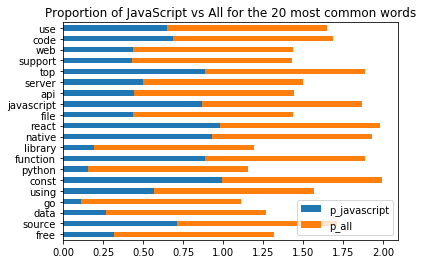

In [19]:
# figure out the percentage of javascript vs all
(word_counts
 .assign(p_javascript=word_counts.javascript / word_counts['all'],
         p_all=word_counts['all'] / word_counts['all'])
 .sort_values(by='all')
 [['p_javascript', 'p_all']]
 .tail(20)
 .sort_values('p_all')
 .plot.barh(stacked=True))

plt.title('Proportion of JavaScript vs All for the 20 most common words')

Creating word clouds for all words and each separate language.
- larger words are more frequent

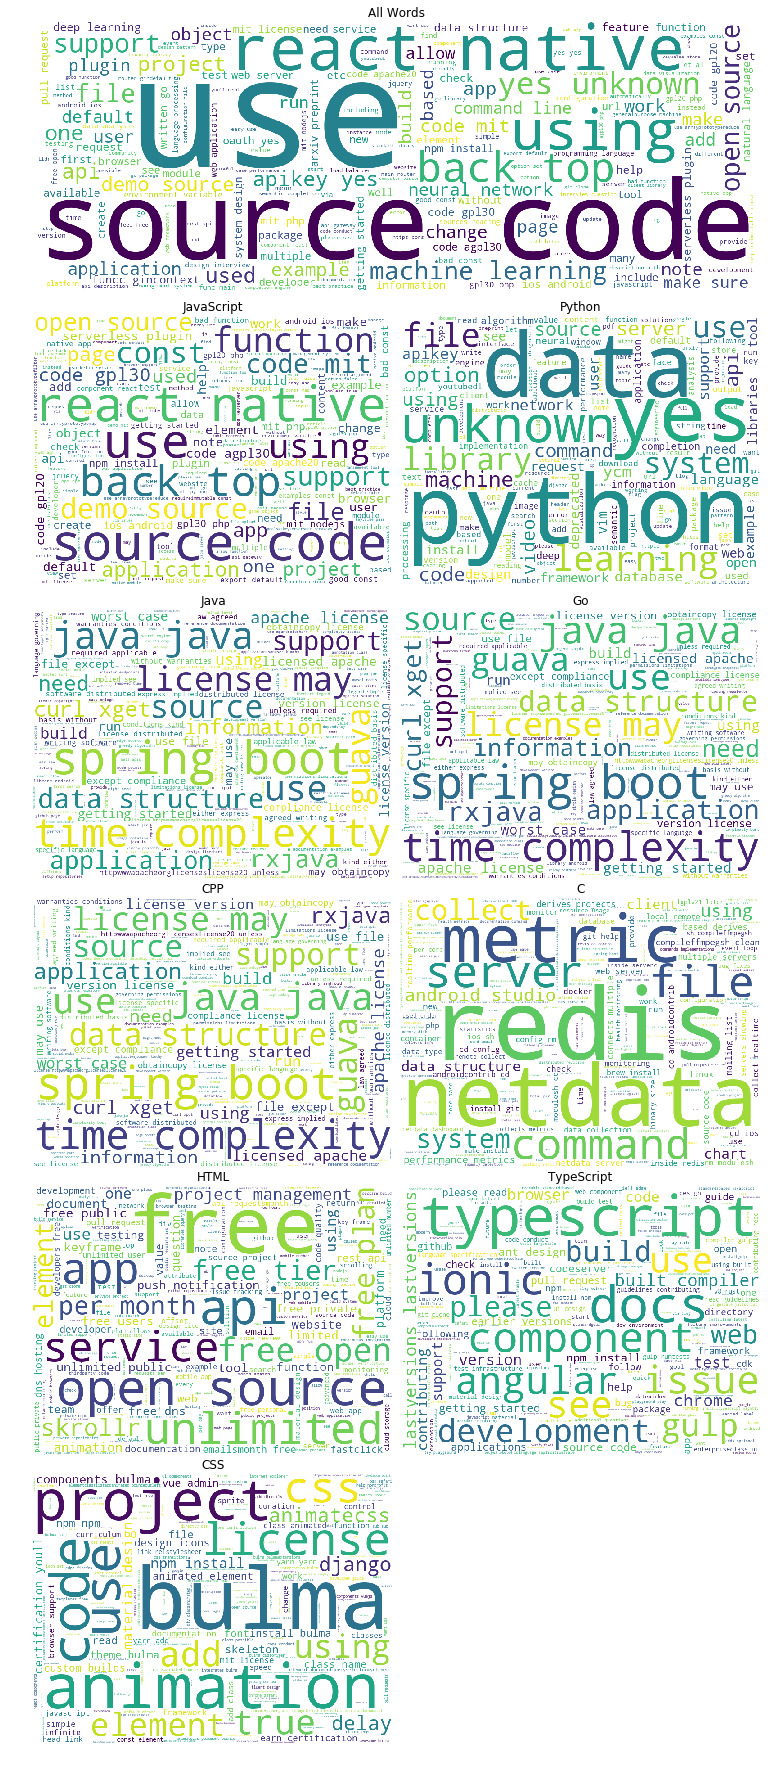

In [20]:
all_cloud = WordCloud(background_color='white', height=600, width=1600).generate(all_words)
javascript_cloud = WordCloud(background_color='white', height=600, width=800).generate(javascript_words)
python_cloud = WordCloud(background_color='white', height=600, width=800,
                         collocations=False).generate(python_words)
java_cloud = WordCloud(background_color='white', height=600, width=800).generate(java_words)
go_cloud = WordCloud(background_color='white', height=600, width=800).generate(java_words)
cpp_cloud = WordCloud(background_color='white', height=600, width=800).generate(java_words)
c_cloud = WordCloud(background_color='white', height=600, width=800).generate(c_words)
html_cloud = WordCloud(background_color='white', height=600, width=800).generate(html_words)
typescript_cloud = WordCloud(background_color='white', height=600, width=800).generate(typescript_words)
css_cloud = WordCloud(background_color='white', height=600, width=800).generate(css_words)

plt.figure(figsize=(10, 8))
axs = [plt.axes([0.005, 0.51, 1, .5]),
       plt.axes([0, 0, .5, .5]), plt.axes([.51, 0, .5, .5]),
       plt.axes([0, -.51, .5, .5]), plt.axes([0.51, -.51, .5, .5]),
       plt.axes([0, -1.01, .5, .5]), plt.axes([0.51, -1.01, .5, .5]), 
       plt.axes([0, -1.51, .5, .5]), plt.axes([0.51, -1.51, .5, .5]),
       plt.axes([0, -2.01, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(javascript_cloud)
axs[2].imshow(python_cloud)
axs[3].imshow(java_cloud)
axs[4].imshow(go_cloud)
axs[5].imshow(cpp_cloud)
axs[6].imshow(c_cloud)
axs[7].imshow(html_cloud)
axs[8].imshow(typescript_cloud)
axs[9].imshow(css_cloud)

axs[0].set_title('All Words')
axs[1].set_title('JavaScript')
axs[2].set_title('Python')
axs[3].set_title('Java')
axs[4].set_title('Go')
axs[5].set_title('CPP')
axs[6].set_title('C')
axs[7].set_title('HTML')
axs[8].set_title('TypeScript')
axs[9].set_title('CSS')

for ax in axs: ax.axis('off')

### Exploring the top 20 bigrams in JavaScript words.
Looking at bigrams opposed to single words can give some context to the words. We see phrases that make sense, like 'machine learning' in Python.

In [21]:
top_20_all_bigrams = (pd.Series(nltk.ngrams(all_words.split(), 2))
                      .value_counts()
                      .head(20))

top_20_all_bigrams.head()

(source, code)     2264
(react, native)    1835
(back, top)        1375
(yes, unknown)     1329
(open, source)      892
dtype: int64

Visualizing the top 20 bigrams with a barplot.

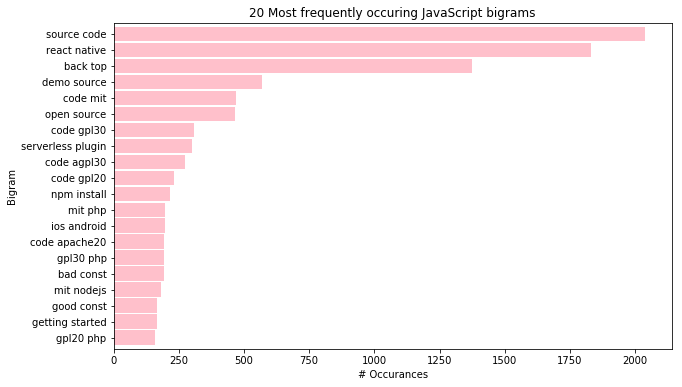

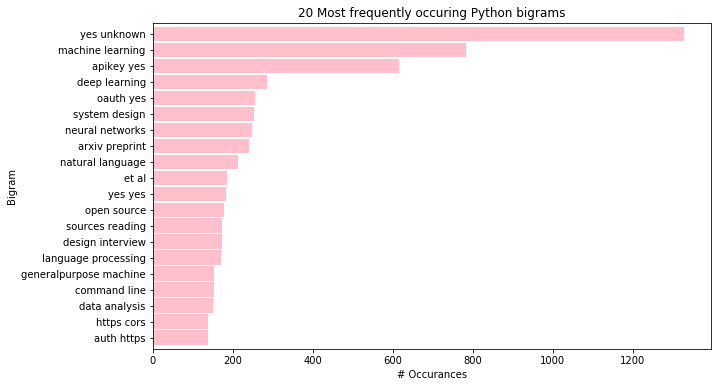

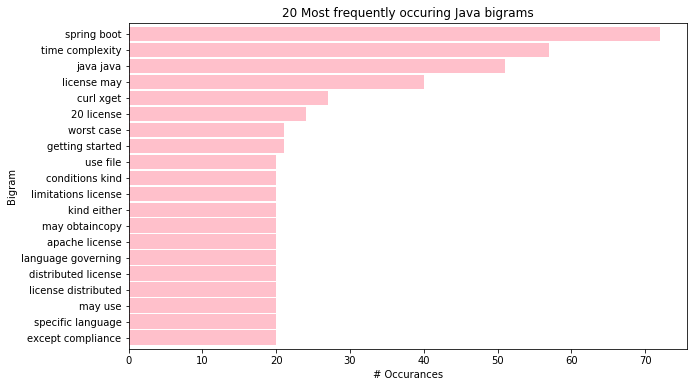

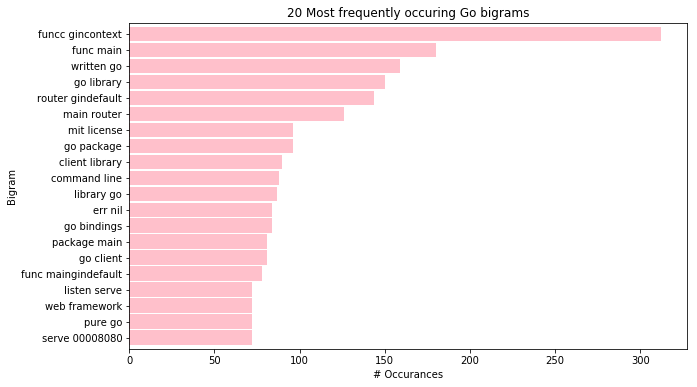

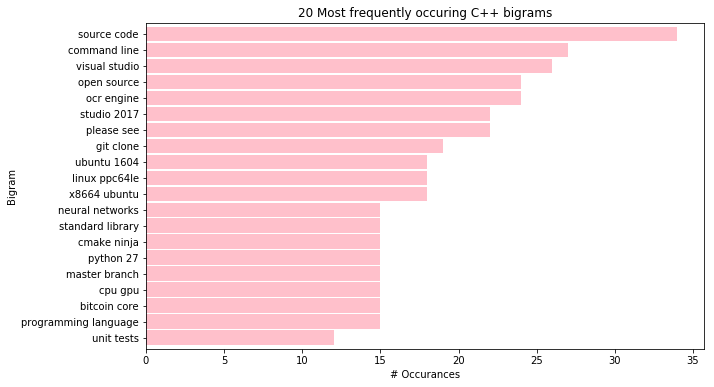

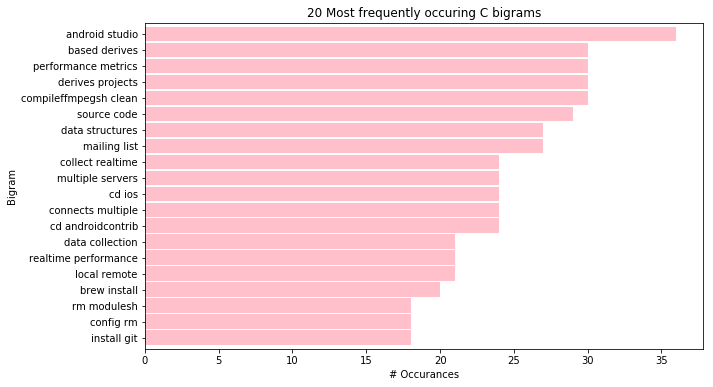

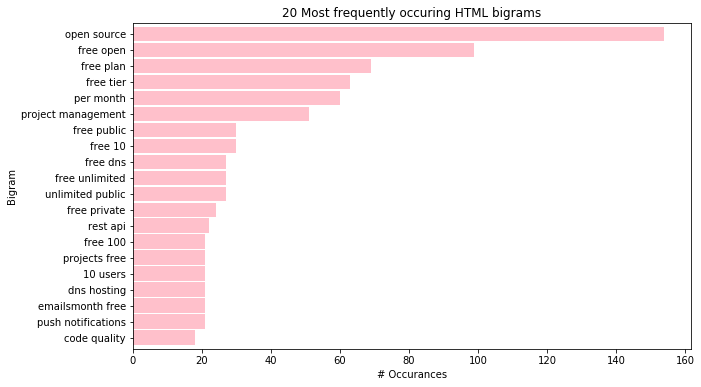

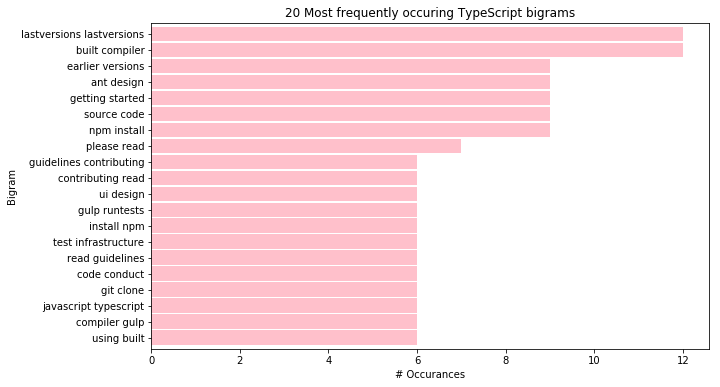

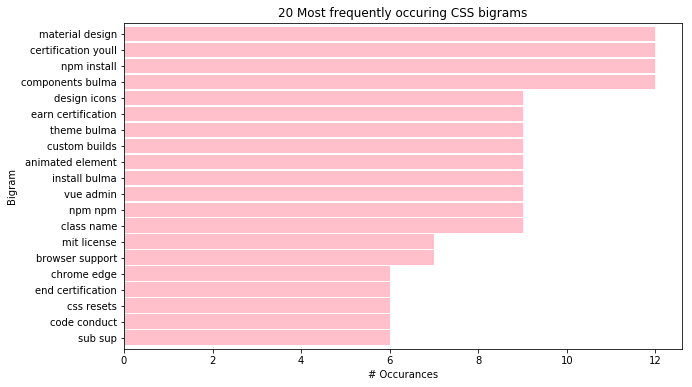

In [22]:
x=0
for i in [javascript_words, python_words, java_words, go_words, cpp_words, c_words, html_words, 
          typescript_words, css_words]:
    gram = (pd.Series(nltk.ngrams(i.split(), 2))
                          .value_counts()
                          .head(20))
    l = ['JavaScript', 'Python', 'Java', 'Go', 'C++', 'C', 'HTML', 'TypeScript', 'CSS']
    gram.head()

    gram.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))
    
    
    plt.title(f'20 Most frequently occuring {l[x]} bigrams')
    x += 1
    plt.ylabel('Bigram')
    plt.xlabel('# Occurances')

    # make the labels pretty
    ticks, _ = plt.yticks()
    labels = gram.reset_index().sort_values(by=0)['index'].apply(lambda t: t[0] + ' ' + t[1])
    _ = plt.yticks(ticks, labels)
    plt.show()

Visualizing the top 20 Javascript bigrams with a word cloud.

(-0.5, 799.5, 399.5, -0.5)

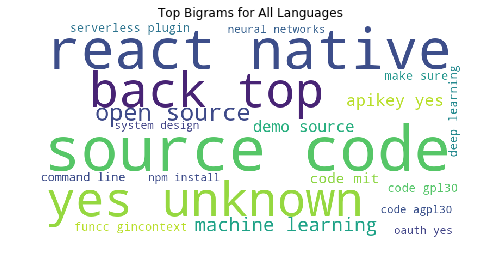

In [23]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_all_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.title('Top Bigrams for All Languages')
plt.axis('off')

Exploring the top 20 trigrams in JavaScript words.

In [24]:
top_20_javascript_trigrams = (pd.Series(nltk.ngrams(javascript_words.split(), 3))
                      .value_counts()
                      .head(20))

top_20_javascript_trigrams.head()

(demo, source, code)      570
(source, code, mit)       459
(source, code, gpl30)     309
(source, code, agpl30)    270
(source, code, gpl20)     231
dtype: int64

Visualizing the top 20 Javascript trigrams with a barplot.

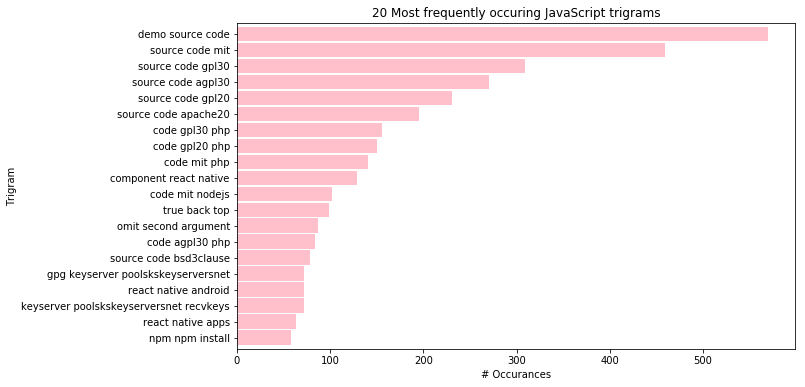

In [25]:
top_20_javascript_trigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring JavaScript trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_javascript_trigrams.reset_index().sort_values(by=0)['index'].\
apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

Visualizing the top 20 Javascript trigrams with a word cloud.

(-0.5, 799.5, 399.5, -0.5)

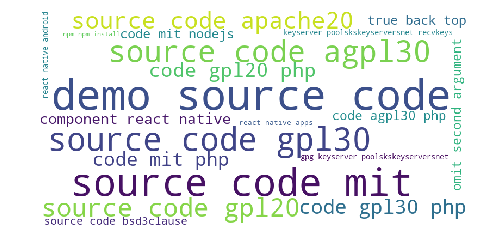

In [26]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_javascript_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

### Visualizing the proportion of the 20 most common words.
This really make it easy to see that the language itself is very prominent in the readme's of the repo's that use that language. For example, a large proportion of the readme's that have the word 'python' in it are using mainly Python in the repo.

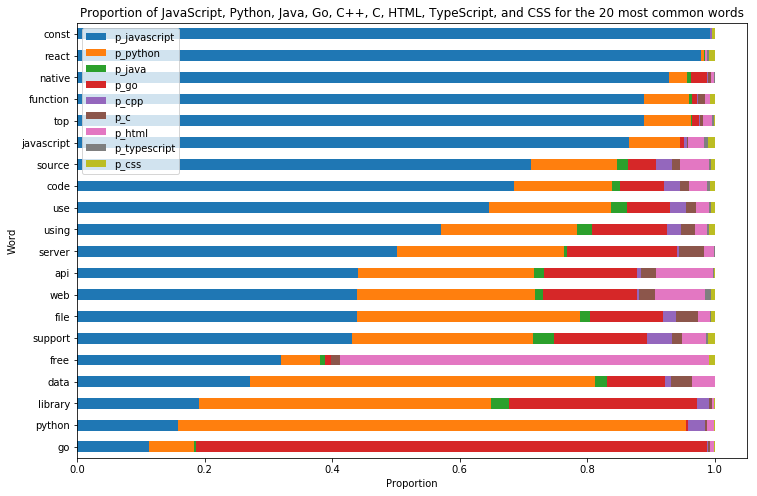

In [27]:
(word_counts
 .assign(p_javascript=word_counts.javascript / word_counts['all'],
         p_python=word_counts.python / word_counts['all'],
         p_java=word_counts.java / word_counts['all'],
         p_go=word_counts.go / word_counts['all'],
         p_cpp=word_counts.cpp / word_counts['all'],
         p_c=word_counts.c / word_counts['all'],
         p_html=word_counts.html / word_counts['all'],
         p_typescript=word_counts.typescript / word_counts['all'],
         p_css=word_counts.css / word_counts['all'])
 .sort_values(by='all')
 [['p_javascript', 'p_python', 'p_java', 'p_go', 'p_cpp', 'p_c', 'p_html', 'p_typescript', 'p_css']]
 .tail(20)
 .sort_values('p_javascript')
 .plot.barh(stacked=True, figsize=(12, 8)))

plt.ylabel('Word')
plt.xlabel('Proportion')
plt.title('Proportion of JavaScript, Python, Java, Go, C++, C, HTML, TypeScript, and CSS for the 20 most common words')
plt.show()

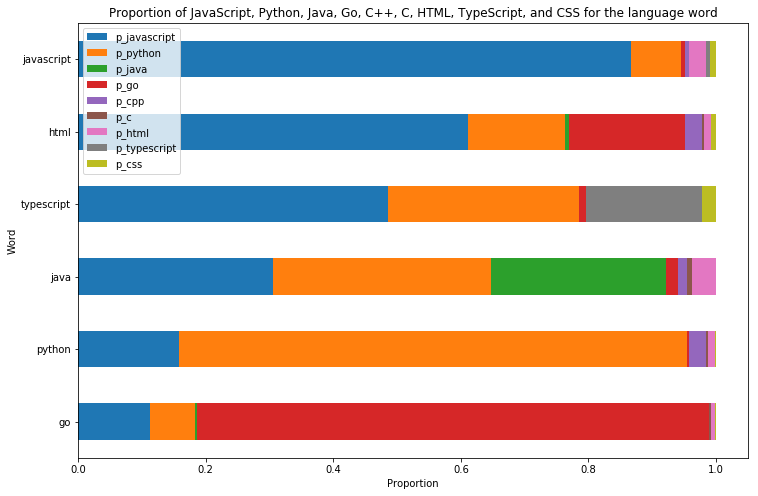

In [28]:
l_words = pd.concat([word_counts.loc['javascript'], word_counts.loc['python'], word_counts.loc['java'], 
           word_counts.loc['go'], #word_counts.loc['c'], 
           word_counts.loc['html'], word_counts.loc['typescript']], axis=1).T
l_words.head()

l_words.assign(p_javascript=l_words.javascript / l_words['all'],
         p_python=l_words.python / l_words['all'],
         p_java=l_words.java / l_words['all'],
         p_go=l_words.go / l_words['all'],
         p_cpp=l_words.cpp / l_words['all'],
         p_c=l_words.c / l_words['all'],
         p_html=l_words.html / l_words['all'],
         p_typescript=l_words.typescript / l_words['all'],
         p_css=l_words.css / l_words['all']).sort_values(by='all')[['p_javascript', 
                                                                    'p_python', 'p_java', 'p_go', 'p_cpp', 
                                                                    'p_c', 'p_html', 'p_typescript', 'p_css']].\
tail(20).sort_values(by='p_javascript').plot.barh(stacked=True, figsize=(12, 8))

plt.ylabel('Word')
plt.xlabel('Proportion')
plt.title('Proportion of JavaScript, Python, Java, Go, C++, C, HTML, TypeScript, and CSS for the language word')
plt.show()

- [ ] Answer the following prompts:
        - [x] What are the most common words in READMEs?
        - [x] What does the distribution of IDFs look like for the most common words?
        - [x] Does the length of the README vary by language?
        - [x] Do different languages use a different number of unique words?

Top 10 most common words in READMEs

In [29]:
top_10_words = word_counts.sort_values(by='all', ascending=False)['all'].head(10).index
top_10_words

Index(['use', 'code', 'source', 'data', 'go', 'using', 'const', 'python',
       'function', 'library'],
      dtype='object')

Distribution of IDFs for most common 5 words

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

tfidfs = tfidf.fit_transform(df2.readme)

nums = pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names())


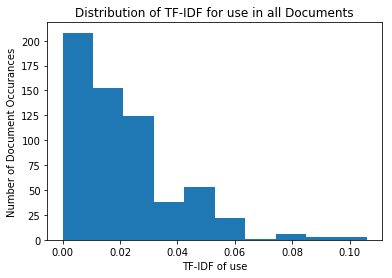

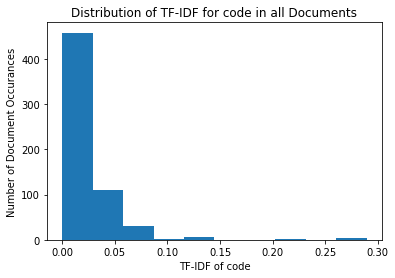

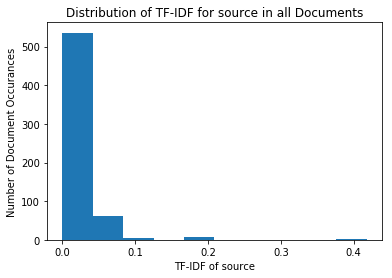

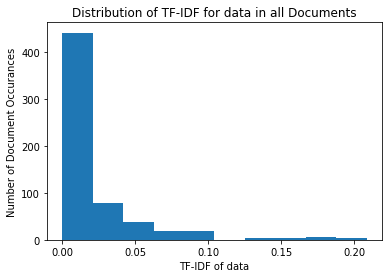

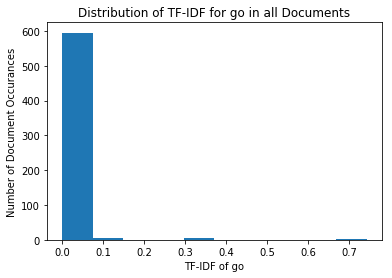

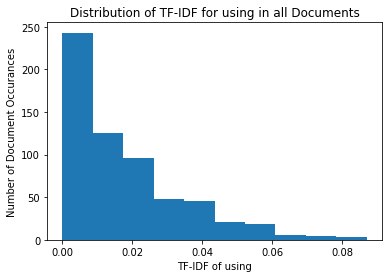

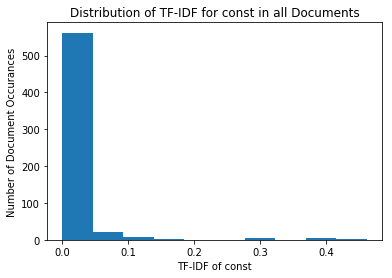

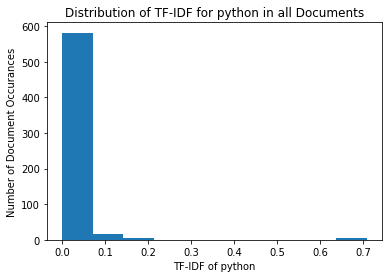

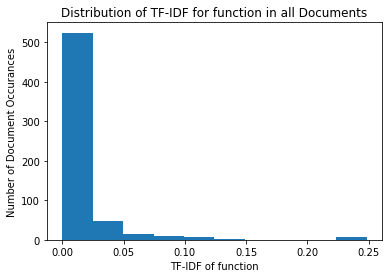

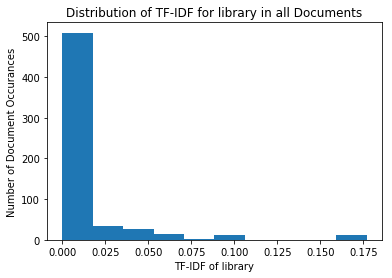

In [32]:
for cols in top_10_words:
    plt.hist(nums[cols])
    plt.title('Distribution of TF-IDF for ' + cols + ' in all Documents')
    plt.ylabel('Number of Document Occurances')
    plt.xlabel('TF-IDF of ' + cols)
    plt.show()

Lengths of READMEs by language

In [33]:
#len(df2.groupby('language').agg('sum')['readme'].split())
df2['readme_word_length'] = df2.readme.str.split().apply(len)
df2['readme_char_length'] = df2.readme.apply(len)

In [34]:
word_counts.columns

Index(['all', 'javascript', 'python', 'java', 'go', 'cpp', 'c', 'html',
       'typescript', 'css'],
      dtype='object')

In [35]:
lang_list = [javascript_words, python_words, java_words,
             go_words, cpp_words, c_words, html_words,
             typescript_words, css_words]

In [36]:
langs = ['javascript_words', 'python_words', 'java_words',
             'go_words', 'cpp_words', 'c_words', 'html_words',
             'typescript_words', 'css_words']
counter = 0
for lang in lang_list: 
    print(f'Unique words in {langs[counter]}: {len(set(lang.split()))}')
    counter+= 1

Unique words in javascript_words: 25397
Unique words in python_words: 12890
Unique words in java_words: 2789
Unique words in go_words: 7384
Unique words in cpp_words: 2594
Unique words in c_words: 2430
Unique words in html_words: 3438
Unique words in typescript_words: 636
Unique words in css_words: 973


In [37]:
word_langs = df2.groupby('language')['readme_word_length'].agg('mean').reset_index()
x = word_langs.language
y = word_langs.readme_word_length

char_length = df2.groupby('language')['readme_char_length'].agg('mean').reset_index()
x2 = char_length.language
y2 = char_length.readme_char_length

Text(0.5, 0, 'Language')

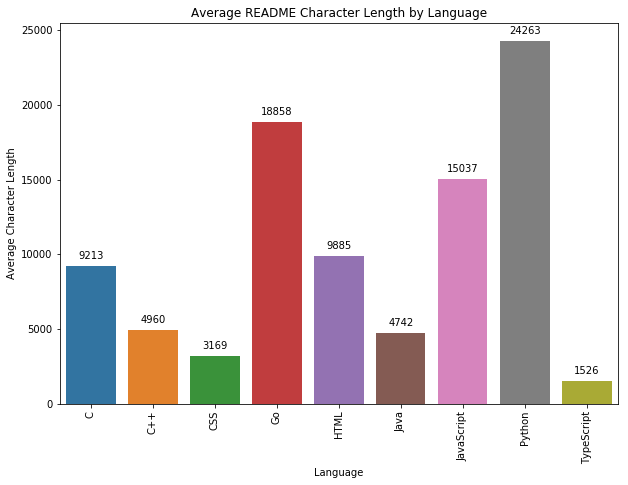

In [38]:
plt.figure(figsize=(10,7))
splot = sns.barplot(x = x2, y = y2, ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
plt.xticks(rotation=90)
plt.title('Average README Character Length by Language')
plt.ylabel('Average Character Length')
plt.xlabel('Language')

Text(0.5, 0, 'Language')

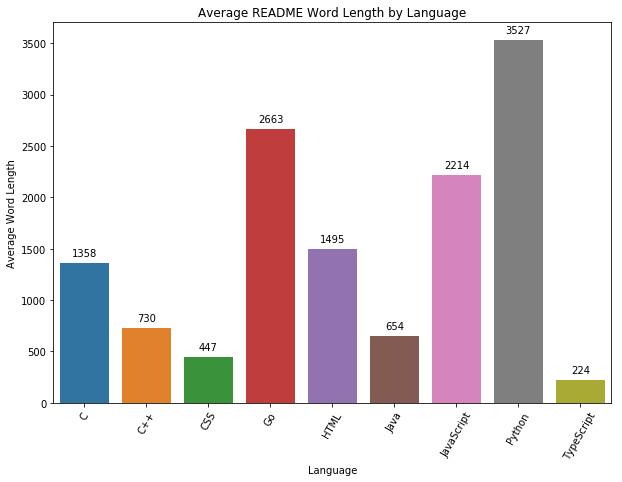

In [39]:
#sns.barplot(x, y)
plt.figure(figsize=(10,7))
splot = sns.barplot(x = x, y = y, ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
plt.xticks(rotation=60)
plt.title('Average README Word Length by Language')
plt.ylabel('Average Word Length')
plt.xlabel('Language')



# MODEL

### Using tf-idf to create a sparse matrix.
Tf-idf is term frequency - inverse document frequency. The higher the tf-idf, the more information that a word provides. The matrix shows the tf-idf for each word for each document. It will be what the classification algorithms use as independent variables.

### Trigrams
### Creating a column that contains the trigrams of each document as a string.
The purpose of this is to create a sparse matrix of the tf-idf values of the trigrams. The thought process here is that trigrams are more unique than single words, so they should be better at helping identify what kind of language the repo is using. This was done before realizing that TfidfVectorizer is able to do this itself.

In [40]:
def trigram_maker(string):
    list_of_words = string.split()
    trigram_list = []
    for a in range(len(list_of_words)):
        if a == len(list_of_words)-2:
            break
        trigram = list_of_words[a] + list_of_words[a+1] + list_of_words[a+2]
        trigram_list.append(trigram)
    return ' '.join(trigram_list)

In [41]:
df2['stemmed_trigrams'] = df2.stem_custom.apply(trigram_maker)
df2.head()

,readme,language,lemm_no_custom,stemmed_no_custom,lemm_custom,stem_custom,clean_no_custom,clean_custom,readme_word_length,readme_char_length,stemmed_trigrams
0,\n\n\n\nMarked\n\n\n\n\n\n\n\n\n\n⚡ built for ...,JavaScript,marked built speed lowlevel compiler parsing m...,mark built speed lowlevel compil pars markdown...,marked built speed lowlevel compiler parsing m...,mark built speed lowlevel compil pars markdown...,marked built speed lowlevel compiler parsing m...,marked built speed lowlevel compiler parsing m...,148,1136,markbuiltspeed builtspeedlowlevel speedlowleve...
1,\nNetty Project\nNetty is an asynchronous even...,Java,netty project netty asynchronous eventdriven n...,netti project netti asynchron eventdriven netw...,netty project netty asynchronous eventdriven n...,netti project netti asynchron eventdriven netw...,netty project netty asynchronous eventdriven n...,netty project netty asynchronous eventdriven n...,257,2051,nettiprojectnetti projectnettiasynchron nettia...
2,"\nReact Starter Kit — ""isomorphic"" web app boi...",JavaScript,react starter kit isomorphic web app boilerpla...,react starter kit isomorph web app boilerpl re...,react starter kit isomorphic web app boilerpla...,react starter kit isomorph web app boilerpl re...,react starter kit isomorphic web app boilerpla...,react starter kit isomorphic web app boilerpla...,582,4035,reactstarterkit starterkitisomorph kitisomorph...
3,"\nUppy\n\n\n\nUppy is a sleek, modular JavaScr...",JavaScript,uppy uppy issleek modular javascript file uplo...,uppi uppi issleek modular javascript file uplo...,uppy uppy issleek modular file uploader integr...,uppi uppi issleek modular file upload integr s...,uppy uppy issleek modular javascript file uplo...,uppy uppy issleek modular file uploader integr...,1614,11332,uppiuppiissleek uppiissleekmodular issleekmodu...
4,\nparticles.js\nA lightweight JavaScript libra...,JavaScript,particlesjslightweight javascript library crea...,particlesjslightweight javascript librari crea...,particlesjslightweight library creating partic...,particlesjslightweight librari creat particl d...,particlesjslightweight javascript library crea...,particlesjslightweight library creating partic...,576,6274,particlesjslightweightlibraricreat libraricrea...


Creating the sparse matrix of the trigrams.  We chose here to use stemmed over lemmatized as it seemed to perform with higher accuracy/f1 score.

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

tfidfs = tfidf.fit_transform(df2.stemmed_trigrams)
tfidfs

# run at your own risk
nums = pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names())
nums.head()

,000000polygonnbsidesimag,000000timesimpli,00000clicksave,00000whitelistsectionchooseconnect,00008080pingbrowserrun,00008080routerrun8080sampl,00008080routerrun8080serv,00008080rrun8080asciijson,00008080rrun8080custom,00008080rrun8080goroutin,...,zurbusedeliv,zuweichen,zxf193resum,zydipowerxedpars,zyngaenginblog,zypperinstalthesilversearch,zypperinstaltype,zyppersourceinstalbuilddepsonli,zysziyongshengzhang,zyszys98gmailcomhehimcollabor
0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.03852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Logistic Regression
With the stemmed trigrams. Multi_class is set to 'multinomial' since there are more than 2 classes. Solver is 'newton-cg'.

We will split up our data using 80% for training and saving 20% for testing accuracy.  We will stratify with language to ensure that we have equal representation of languages.

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df2.stemmed_trigrams)
y = df2.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression(random_state=123, solver='newton-cg', multi_class='multinomial').fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

Train

In [44]:
print('Training Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Testing Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Training Accuracy: 89.75%
---
Testing Accuracy: 70.49%
---
Confusion Matrix
actual       C  C++  CSS  Go  HTML  Java  JavaScript  Python  TypeScript
predicted                                                               
C           11    0    0   0     0     0           0       0           0
C++          0   17    0   0     0     0           0       0           0
CSS          0    0    9   0     0     0           0       0           0
Go           0    0    0  31     0     0           0       0           0
HTML         0    0    0   0    11     0           0       0           0
Java         0    0    0   0     0    46           0       0           0
JavaScript   7   13    4   6     7     1         235       4           8
Python       0    0    0   0     0     0           0      72           0
TypeScript   0    0    0   0     0     0           0       0           6
---
              precision    recall  f1-score   support

           C       1.00      0.61      0.76        18
        

### Decision Tree
With stemmed trigrams.

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

clf = DecisionTreeClassifier(criterion='gini', max_depth=6, random_state=123)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
y_pred_proba = clf.predict_proba(X_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.62
Accuracy of Decision Tree classifier on test set: 0.59


### Random Forest
With stemmed trigrams.

In [46]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=2,
                            n_estimators=100,
                            max_depth=10, 
                            random_state=123)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_train)

print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.62


In [47]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.56


Overall, using the tf-idf values of the stemmed trigrams didn't provide good accuracy. Using single words provided better accuracy. Accuracy on train with any model was around 55%, but dropped below 50% on the test. It may be that the trigrams are unique not only between the languages but also between the repo's within that language.

### Bag of Words
Instead of tf-idf values as the independent variables, we use a simple bag of words here. The bag of words is essentially a sparse matrix of counts for every word for every document. The bag of words is created using CountVectorizer.

### Logistic Regression
With Bag of Words. Multi_class set to 'multinomial' and solver set to 'newton-cg'.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

count_vec = CountVectorizer()
X = count_vec.fit_transform(df2.readme)
y = df2.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.4, random_state=123)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression(random_state=123, solver='newton-cg', multi_class='multinomial').fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

Train

In [16]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 100.00%
---
Accuracy: 92.21%
---
Confusion Matrix
actual       C  C++  CSS  Go  HTML  Java  JavaScript  Python  TypeScript
predicted                                                               
C           14    0    0   0     0     0           0       0           0
C++          0   23    0   0     0     0           0       0           0
CSS          0    0    9   0     0     0           0       0           0
Go           0    0    0  28     0     0           0       0           0
HTML         0    0    0   0    14     0           0       0           0
Java         0    0    0   0     0    35           0       0           0
JavaScript   0    0    0   0     0     0         176       0           0
Python       0    0    0   0     0     0           0      57           0
TypeScript   0    0    0   0     0     0           0       0          10
---
              precision    recall  f1-score   support

           C       1.00      1.00      1.00        14
         C++       1.00 

Test

In [73]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 92.21%
---
Confusion Matrix
actual      C  C++  CSS  Go  HTML  Java  JavaScript  Python  TypeScript
predicted                                                              
C           7    0    0   0     0     0           0       0           0
C++         0   14    0   0     0     0           0       0           0
CSS         0    0    7   0     0     0           3       0           0
Go          0    0    0  15     0     0           0       0           0
HTML        0    0    0   0     8     0           0       0           0
Java        0    0    0   3     0    20           0       0           0
JavaScript  1    1    0   0     1     0         112       3           0
Python      1    0    0   0     0     3           3      35           0
TypeScript  0    0    0   0     0     0           0       0           7
---
              precision    recall  f1-score   support

           C       1.00      0.78      0.88         9
         C++       1.00      0.93      0.97        15
   

### Decision Tree
With bag of words.

In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

clf = DecisionTreeClassifier(criterion='gini', max_depth=7, random_state=123)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
y_pred_proba = clf.predict_proba(X_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.91
Accuracy of Decision Tree classifier on test set: 0.83


Looping through max depths of 1 to 20 to find the one that gives the best accuracy.

In [53]:
for i in range (1, 21):
    print(f'Max Depth of {i}')
    clf = DecisionTreeClassifier(criterion='gini', max_depth=i, random_state=123)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_train)
    y_pred_proba = clf.predict_proba(X_train)

    print('Accuracy of Decision Tree classifier on training set: {:.2f}'
         .format(clf.score(X_train, y_train)))

    print('Accuracy of Decision Tree classifier on test set: {:.2f}'
         .format(clf.score(X_test, y_test)))
    print('\n')

Max Depth of 1
Accuracy of Decision Tree classifier on training set: 0.48
Accuracy of Decision Tree classifier on test set: 0.45


Max Depth of 2
Accuracy of Decision Tree classifier on training set: 0.58
Accuracy of Decision Tree classifier on test set: 0.58


Max Depth of 3
Accuracy of Decision Tree classifier on training set: 0.68
Accuracy of Decision Tree classifier on test set: 0.67


Max Depth of 4
Accuracy of Decision Tree classifier on training set: 0.76
Accuracy of Decision Tree classifier on test set: 0.73


Max Depth of 5
Accuracy of Decision Tree classifier on training set: 0.80
Accuracy of Decision Tree classifier on test set: 0.76


Max Depth of 6
Accuracy of Decision Tree classifier on training set: 0.86
Accuracy of Decision Tree classifier on test set: 0.78


Max Depth of 7
Accuracy of Decision Tree classifier on training set: 0.91
Accuracy of Decision Tree classifier on test set: 0.83


Max Depth of 8
Accuracy of Decision Tree classifier on training set: 0.93
Accuracy 

### Random Forest
With bag of words.

In [54]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='entropy',
                            min_samples_leaf=2,
                            n_estimators=100,
                            max_depth=10, 
                            random_state=123)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_train)

print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on training set: 0.90
Accuracy of random forest classifier on test set: 0.78


### KNN
With bag of words.

In [55]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3, weights='uniform')
knn.fit(X_train, y_train)

y_pred = knn.predict(X_train)

print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of KNN classifier on training set: 0.91
Accuracy of KNN classifier on test set: 0.75


In [56]:
for i in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=i, weights='uniform')
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_train)
    print(f'{i} Neareast Neighbors')

    print('Accuracy of KNN classifier on training set: {:.2f}'
         .format(knn.score(X_train, y_train)))

    print('Accuracy of KNN classifier on test set: {:.2f}'
         .format(knn.score(X_test, y_test)))
    print('\n')

1 Neareast Neighbors
Accuracy of KNN classifier on training set: 1.00
Accuracy of KNN classifier on test set: 0.94


2 Neareast Neighbors
Accuracy of KNN classifier on training set: 0.97
Accuracy of KNN classifier on test set: 0.86


3 Neareast Neighbors
Accuracy of KNN classifier on training set: 0.91
Accuracy of KNN classifier on test set: 0.75


4 Neareast Neighbors
Accuracy of KNN classifier on training set: 0.85
Accuracy of KNN classifier on test set: 0.67


5 Neareast Neighbors
Accuracy of KNN classifier on training set: 0.80
Accuracy of KNN classifier on test set: 0.65


6 Neareast Neighbors
Accuracy of KNN classifier on training set: 0.75
Accuracy of KNN classifier on test set: 0.61


7 Neareast Neighbors
Accuracy of KNN classifier on training set: 0.70
Accuracy of KNN classifier on test set: 0.59


8 Neareast Neighbors
Accuracy of KNN classifier on training set: 0.69
Accuracy of KNN classifier on test set: 0.60


9 Neareast Neighbors
Accuracy of KNN classifier on training set:

Accuracy was not great for the bag of words approach. Some models would have good accuracy on the training set, but the best accuracy on the test set was 55% from a Decision Tree. Compared to tf-idf, the bag of words approach provides higher accuracy.

### Truncated Singular Value Decomposition
Truncated SVD is similar to Principal Component Analysis. It decreases the dimensionality of a dataset, and in our case will decrease the dimensionality of our sparse matrix.

### Logistic Regression
with tf-idf.

In [57]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

### Logistic Regression

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df2.stemmed_no_custom)
y = df2.language

pca = TruncatedSVD(n_components=30)
X = pca.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.4, random_state=123)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression(random_state=123, solver='newton-cg', multi_class='multinomial').fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 67.76%
---
Confusion Matrix
actual      C  C++  CSS  Go  HTML  Java  JavaScript  Python  TypeScript
predicted                                                              
C           9    0    0   0     0     0           0       0           0
C++         0    3    0   0     0     0           0       0           0
Go          0    0    0  10     0     0           0       0           0
HTML        0    0    0   0     4     0           0       0           0
Java        0    0    0   0     0    18           0       0           0
JavaScript  5   16    9  18    10    17         176      29          10
Python      0    4    0   0     0     0           0      28           0
---
              precision    recall  f1-score   support

           C       1.00      0.64      0.78        14
         C++       1.00      0.13      0.23        23
         CSS       0.00      0.00      0.00         9
          Go       1.00      0.36      0.53        28
        HTML       1.00      0.29      

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [58]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 63.93%
---
Confusion Matrix
actual      C  C++  CSS  Go  HTML  Java  JavaScript  Python  TypeScript
predicted                                                              
C           3    0    0   0     0     0           0       0           0
C++         0    3    0   0     0     0           0       0           0
Go          0    0    0   5     0     0           0       0           0
HTML        0    0    0   0     2     0           0       0           0
Java        0    0    0   0     0    11           0       0           0
JavaScript  6   10    7  13     7    12         115      21           7
Python      0    2    0   0     0     0           3      17           0
---
              precision    recall  f1-score   support

           C       1.00      0.33      0.50         9
         C++       1.00      0.20      0.33        15
         CSS       0.00      0.00      0.00         7
          Go       1.00      0.28      0.43        18
        HTML       1.00      0.22      

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Decision Tree

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

clf = DecisionTreeClassifier(criterion='gini', max_depth=6, random_state=123)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
y_pred_proba = clf.predict_proba(X_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.86
Accuracy of Decision Tree classifier on test set: 0.79


### Truncated Singular Value Decomp
With bag of words

### Logistic Regression

In [62]:
count_vec = CountVectorizer()
X = count_vec.fit_transform(df2.stem_custom)
y = df2.language

pca = TruncatedSVD(n_components=30)
X = pca.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.4, random_state=123)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression(random_state=123, solver='newton-cg', multi_class='multinomial').fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
# print('---')
# print('Confusion Matrix')
# print(pd.crosstab(train.predicted, train.actual))
# print('---')
# print(classification_report(train.actual, train.predicted))

print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
# print('---')
# print('Confusion Matrix')
# print(pd.crosstab(test.predicted, test.actual))
# print('---')
# print(classification_report(test.actual, test.predicted))

Accuracy: 83.61%
Accuracy: 73.36%


### Decision Tree

In [63]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=6, random_state=123)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
y_pred_proba = clf.predict_proba(X_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.75
Accuracy of Decision Tree classifier on test set: 0.63


Accuracies for models using Truncated SVD were not much of an improvement. The best was a decision tree using tf-idf. It had a train accuracy of 95% and a test accuracy of 57%.

## Final Model Testing

We will loop through the highest performing models and look at the accuracy and classification report for each to determine which model is the best for us to use to predict on unseen READMEs.

In [17]:
df2.columns

Index(['readme', 'language', 'lemm_no_custom', 'stemmed_no_custom',
       'lemm_custom', 'stem_custom', 'clean_no_custom', 'clean_custom'],
      dtype='object')

Testing all datasets with TDIDF & Logistic Regression

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tdidf_lr():
    datasets = df2.drop(columns=['language'])
    for col in datasets:
        print(col)
        # count_vec = CountVectorizer()
#         X = count_vec.fit_transform(df2.col)
#         y = df2.language
        
        tfidf = TfidfVectorizer()
        X = tfidf.fit_transform(df2[col])
        y = df2.language

        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)

        train = pd.DataFrame(dict(actual=y_train))
        test = pd.DataFrame(dict(actual=y_test))

        lm = LogisticRegression(random_state=123, solver='newton-cg', multi_class='multinomial').fit(X_train, y_train)

        train['predicted'] = lm.predict(X_train)
        test['predicted'] = lm.predict(X_test)
        
        print(f'Results for: {col}')
        print('Accuracy of TDIDF Logistic Regression on training set: {:.2f}'.format(lm.score(X_train, y_train)))
        print('Accuracy of TDIDF Logistic Regression on test set: {:.2f}'
             .format(lm.score(X_test, y_test)))
        
tdidf_lr()
        

readme
Results for: readme
Accuracy of TDIDF Logistic Regression on training set: 0.90
Accuracy of TDIDF Logistic Regression on test set: 0.79
lemm_no_custom
Results for: lemm_no_custom
Accuracy of TDIDF Logistic Regression on training set: 0.91
Accuracy of TDIDF Logistic Regression on test set: 0.80
stemmed_no_custom
Results for: stemmed_no_custom
Accuracy of TDIDF Logistic Regression on training set: 0.91
Accuracy of TDIDF Logistic Regression on test set: 0.80
lemm_custom
Results for: lemm_custom
Accuracy of TDIDF Logistic Regression on training set: 0.91
Accuracy of TDIDF Logistic Regression on test set: 0.77
stem_custom
Results for: stem_custom
Accuracy of TDIDF Logistic Regression on training set: 0.91
Accuracy of TDIDF Logistic Regression on test set: 0.81
clean_no_custom
Results for: clean_no_custom
Accuracy of TDIDF Logistic Regression on training set: 0.91
Accuracy of TDIDF Logistic Regression on test set: 0.80
clean_custom
Results for: clean_custom
Accuracy of TDIDF Logistic 

Testing all datasets with Bag of Words & Logistic Regression

In [ ]:
def bow_lr():
    datasets = df2.drop(columns=['language'])
    for col in datasets:
        count_vec = CountVectorizer()
        X = count_vec.fit_transform(df2[col])
        y = df2.language

        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.4, random_state=123)

        train = pd.DataFrame(dict(actual=y_train))
        test = pd.DataFrame(dict(actual=y_test))

        lm = LogisticRegression(random_state=123, solver='newton-cg', multi_class='multinomial').fit(X_train, y_train)

        train['predicted'] = lm.predict(X_train)
        test['predicted'] = lm.predict(X_test)
        
        print(f'Results for: {col}')
        print('Accuracy of Bag of Words Logistic Regression on training set: {:.2f}'.format(lm.score(X_train, y_train)))
        print('Accuracy of Bag of Words Logistic Regression on test set: {:.2f}'
             .format(lm.score(X_test, y_test)))
        
bow_lr()
        

# Testing Model with new READMEs

Now that we have selected a model we can input unseen READMEs and have it predict the language.

In [75]:
def predict_logr(text):
    return lm.predict(count_vec.transform([text]))[0]
def predict_rf(text):
    return rf.predict(count_vec.transform([text]))[0]

In [76]:
test_readmes = pd.read_csv('test_ghubs.csv')

In [77]:
test_readmes.language

0              C
1     TypeScript
2           HTML
3         Python
4           Java
5           Java
6     JavaScript
7         Python
8             C#
9             C#
10    JavaScript
11    JavaScript
12          HTML
13        Python
14             C
15        Python
16          HTML
17        Python
18    JavaScript
19    JavaScript
Name: language, dtype: object

In [ ]:
test_readmes.readme.apply(predict_logr)

In [ ]:
test_readmes.readme.apply(basic_clean).apply(tokenize).apply(remove_stopwords).apply(predict_logr)

In [ ]:
test_readmes.language